Shape X: (150, 4) | clases: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]


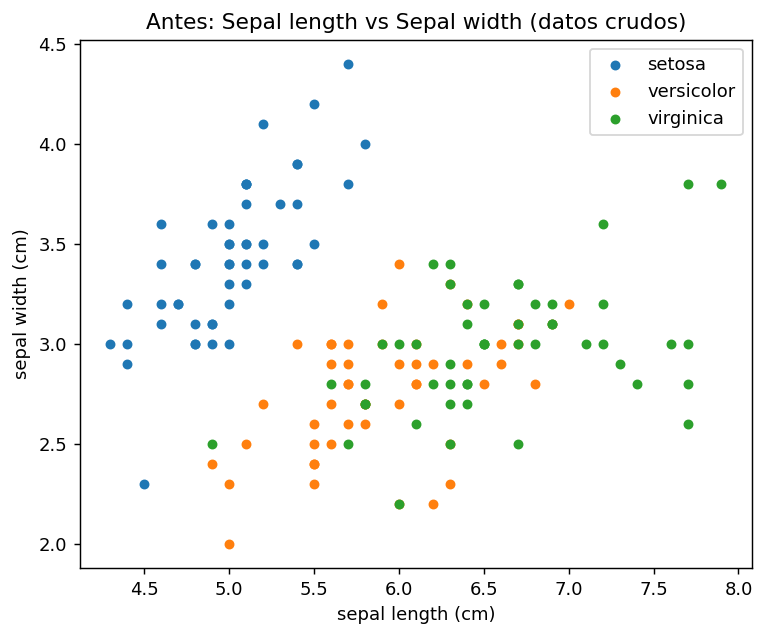

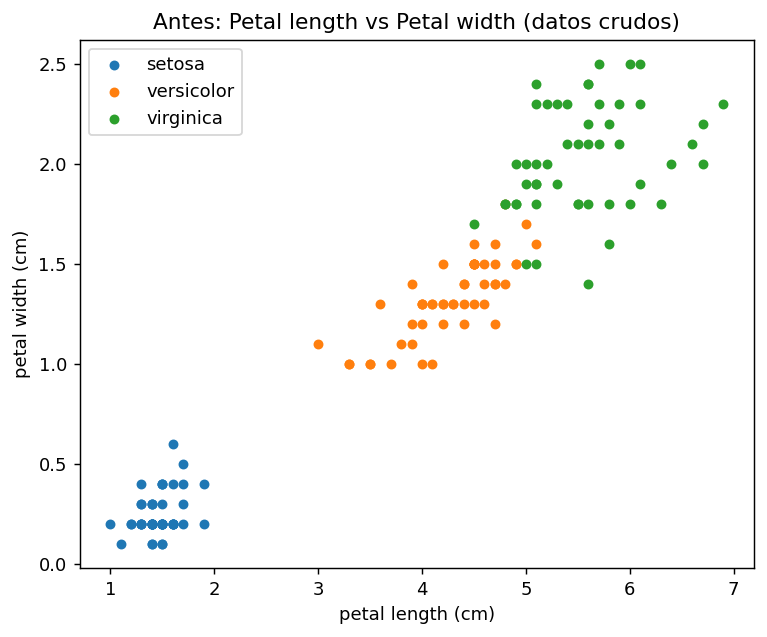


=== Métricas (macro) ===
Accuracy:  0.9211
Precision: 0.9375
Recall:    0.9231
F1-score:  0.9220

=== Reporte por clase ===
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.81      1.00      0.90        13
   virginica       1.00      0.77      0.87        13

    accuracy                           0.92        38
   macro avg       0.94      0.92      0.92        38
weighted avg       0.94      0.92      0.92        38



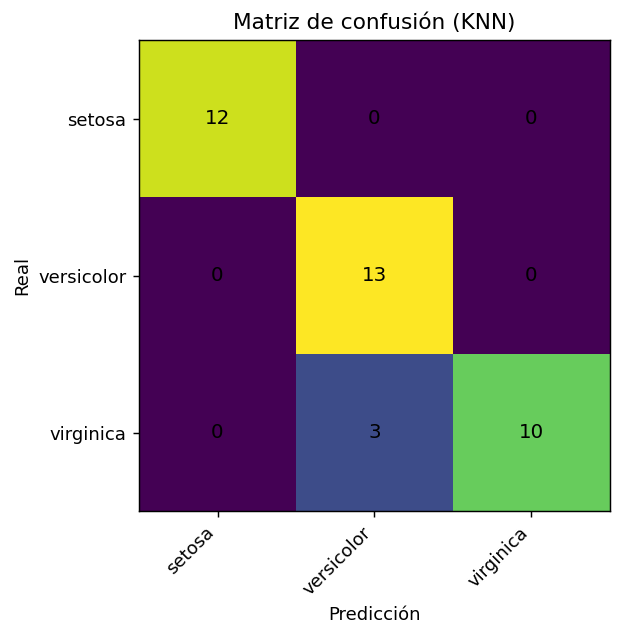

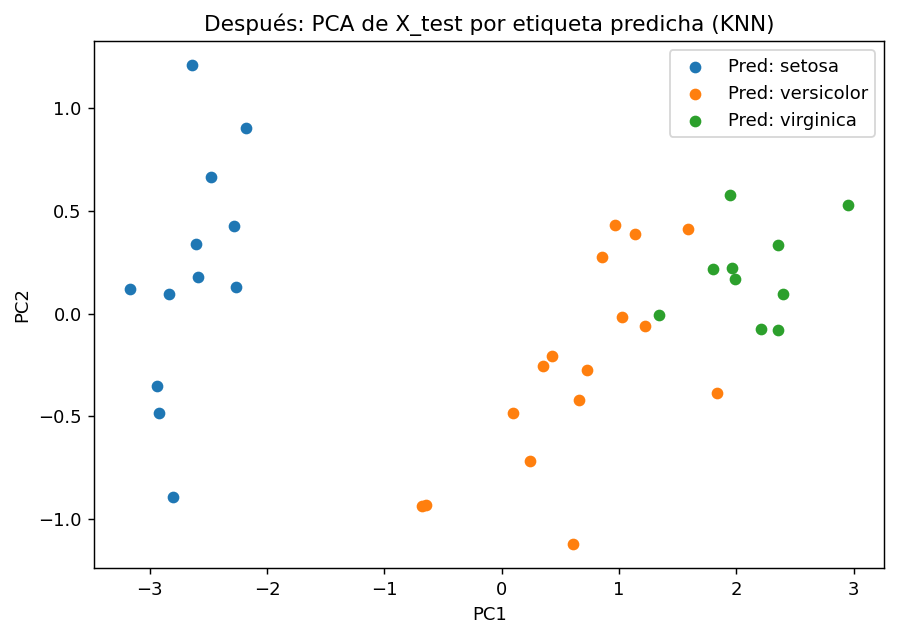

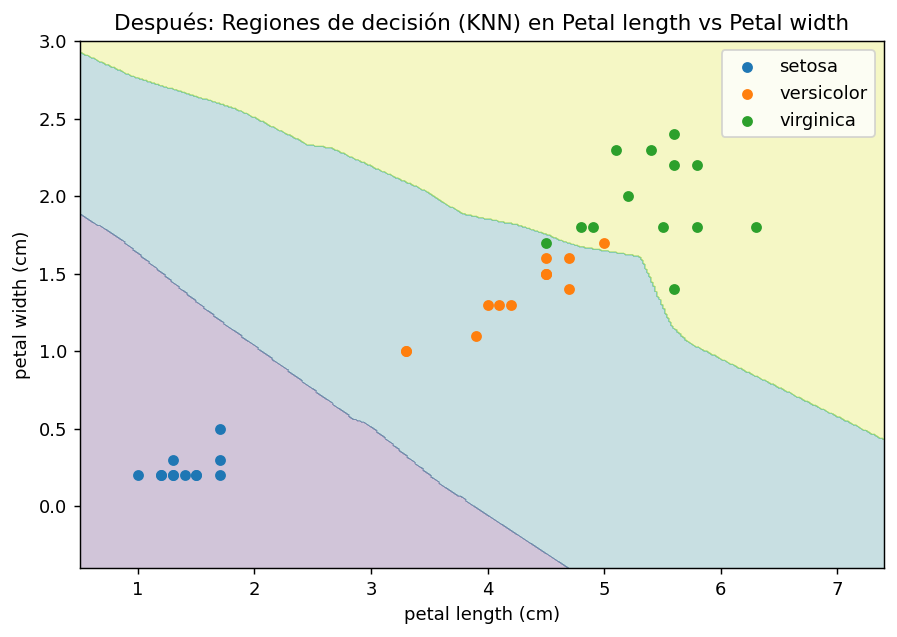

In [1]:
# === Iris + KNeighborsClassifier (Notebook-ready) ===
# Requisitos: scikit-learn, numpy, pandas, matplotlib
# !pip install scikit-learn pandas matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA

# -----------------------------
# Parámetros
# -----------------------------
TEST_SIZE = 0.25
RANDOM_STATE = 42
N_NEIGHBORS = 5  # k del KNN

# -----------------------------
# 1) Cargar dataset
# -----------------------------
iris = load_iris(as_frame=True)
X = iris.data.copy()
y = iris.target.copy()
target_names = iris.target_names

print("Shape X:", X.shape, "| clases:", list(target_names))

# -----------------------------
# 1.A) Gráficas 'antes' (datos crudos)
# -----------------------------

# Sepal length vs Sepal width
plt.figure(figsize=(6, 5), dpi=130)
for label in np.unique(y):
    mask = (y == label)
    plt.scatter(X.loc[mask, "sepal length (cm)"],
                X.loc[mask, "sepal width (cm)"],
                label=target_names[label], s=20)
plt.title("Antes: Sepal length vs Sepal width (datos crudos)")
plt.xlabel("sepal length (cm)")
plt.ylabel("sepal width (cm)")
plt.legend()
plt.tight_layout()
plt.show()

# Petal length vs Petal width
plt.figure(figsize=(6, 5), dpi=130)
for label in np.unique(y):
    mask = (y == label)
    plt.scatter(X.loc[mask, "petal length (cm)"],
                X.loc[mask, "petal width (cm)"],
                label=target_names[label], s=20)
plt.title("Antes: Petal length vs Petal width (datos crudos)")
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Split + Pipeline (Scaler -> KNN)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=N_NEIGHBORS))
])
pipe.fit(X_train, y_train)

# -----------------------------
# 2) Métricas
# -----------------------------
y_pred = pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\n=== Métricas (macro) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec_macro:.4f}")
print(f"Recall:    {recall_macro:.4f}")
print(f"F1-score:  {f1_macro:.4f}")

print("\n=== Reporte por clase ===")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# -----------------------------
# 3) Matriz de confusión
# -----------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5), dpi=130)
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión (KNN)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks(np.arange(len(target_names)), target_names, rotation=45, ha="right")
plt.yticks(np.arange(len(target_names)), target_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=11)
plt.tight_layout()
plt.show()

# -----------------------------
# 4) Gráficas “después” de la clasificación
#    A) PCA 2D de X_test con etiquetas PREDICHAS
# -----------------------------
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_test_proj = pca.fit_transform(X_test)

plt.figure(figsize=(7, 5), dpi=130)
for label in np.unique(y_pred):
    mask = (y_pred == label)
    plt.scatter(X_test_proj[mask, 0], X_test_proj[mask, 1],
                label=f"Pred: {target_names[label]}", s=30)
plt.title("Después: PCA de X_test por etiqueta predicha (KNN)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 4.B) Regiones de decisión (visualización 2D)
#     Usamos solo 2 características: petal length & petal width
# -----------------------------
feat_pair = ["petal length (cm)", "petal width (cm)"]
X2 = X[feat_pair].values

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

pipe2d = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=N_NEIGHBORS))
])
pipe2d.fit(X2_train, y2_train)

# Malla
x_min, x_max = X2[:, 0].min() - 0.5, X2[:, 0].max() + 0.5
y_min, y_max = X2[:, 1].min() - 0.5, X2[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)
Z = pipe2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(7, 5), dpi=130)
# Contorno de regiones (sin especificar colores)
contour = plt.contourf(xx, yy, Z, alpha=0.25)

# Puntos del set de prueba con su clase REAL para distinguir datos
for label in np.unique(y2_test):
    mask = (y2_test == label)
    pts = X2_test[mask]
    plt.scatter(pts[:, 0], pts[:, 1], label=target_names[label], s=25)

plt.title("Después: Regiones de decisión (KNN) en Petal length vs Petal width")
plt.xlabel(feat_pair[0])
plt.ylabel(feat_pair[1])
plt.legend()
plt.tight_layout()
plt.show()


Shape X: (150, 4) | clases: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]


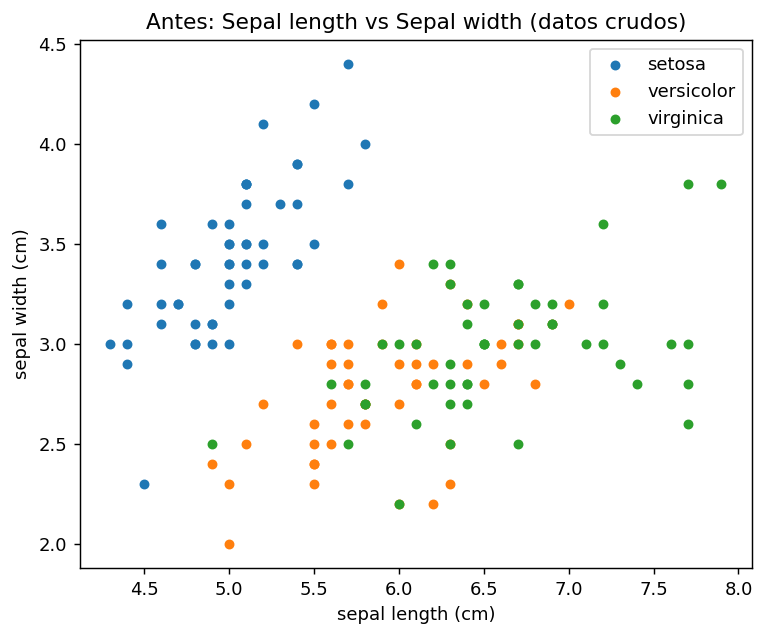

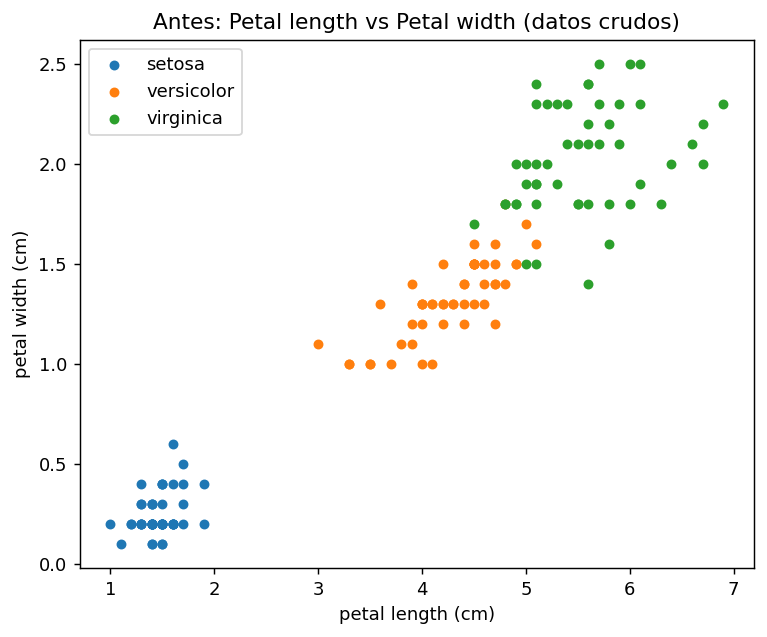


=== Métricas (macro) ===
Accuracy:  0.9474
Precision: 0.9487
Recall:    0.9487
F1-score:  0.9487

=== Reporte por clase ===
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.92      0.92      0.92        13
   virginica       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



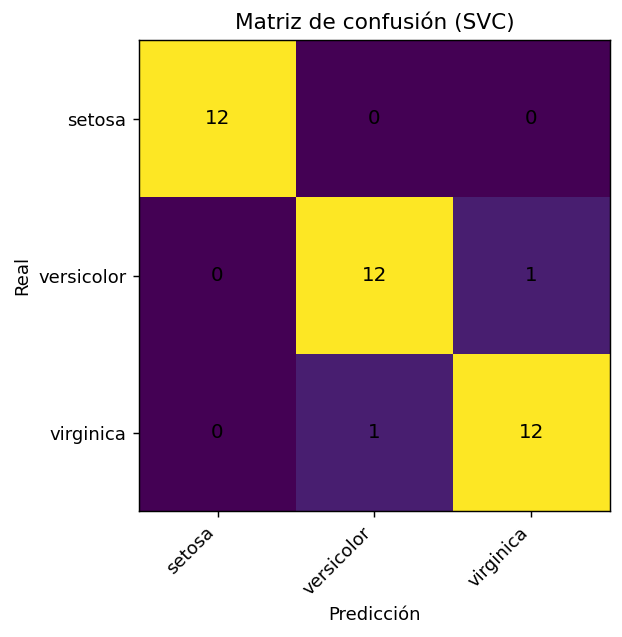

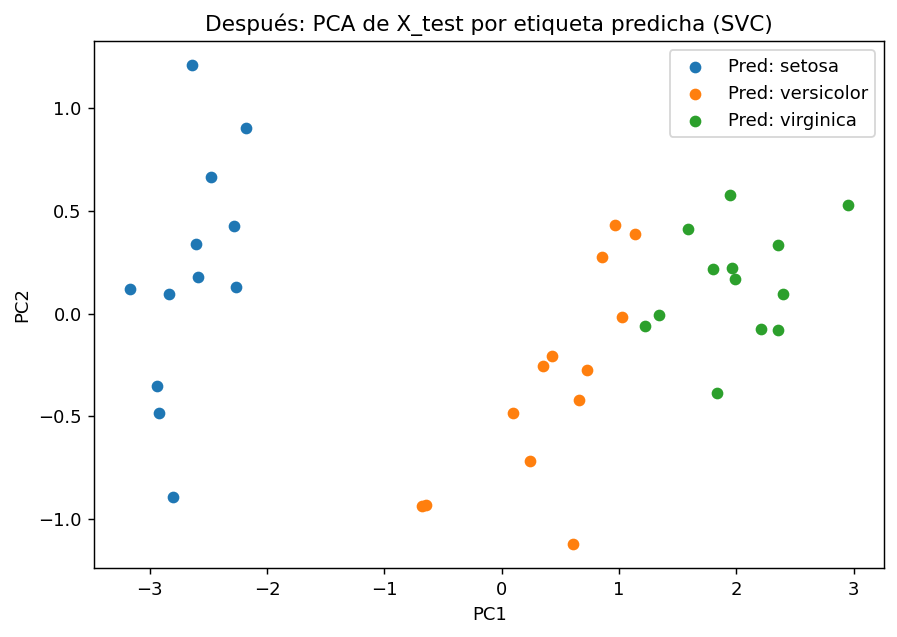

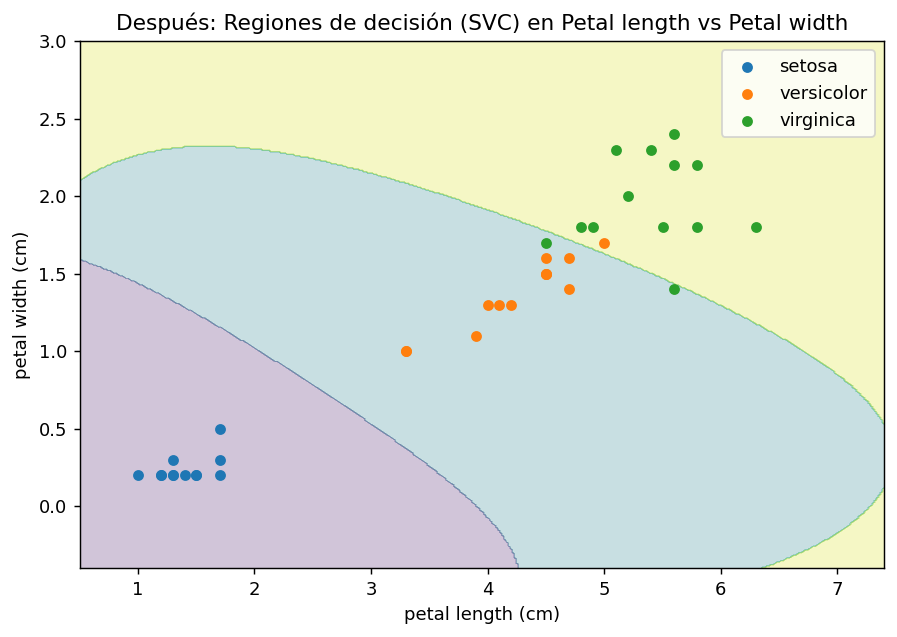

In [2]:
# === Iris + SVC (SVM) end-to-end ===
# Requisitos: scikit-learn, numpy, pandas, matplotlib
# !pip install scikit-learn pandas matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA

# -----------------------------
# Parámetros
# -----------------------------
TEST_SIZE = 0.25
RANDOM_STATE = 42
# Hiperparámetros SVC (RBF por defecto): ajústalos si quieres
SVC_C = 1.0
SVC_GAMMA = "scale"  # o "auto"

# -----------------------------
# 1) Cargar dataset
# -----------------------------
iris = load_iris(as_frame=True)
X = iris.data.copy()
y = iris.target.copy()
target_names = iris.target_names

print("Shape X:", X.shape, "| clases:", list(target_names))

# -----------------------------
# 1.A) Gráficas 'antes' (datos crudos)
# -----------------------------

# Sepal length vs Sepal width
plt.figure(figsize=(6, 5), dpi=130)
for label in np.unique(y):
    mask = (y == label)
    plt.scatter(X.loc[mask, "sepal length (cm)"],
                X.loc[mask, "sepal width (cm)"],
                label=target_names[label], s=20)
plt.title("Antes: Sepal length vs Sepal width (datos crudos)")
plt.xlabel("sepal length (cm)")
plt.ylabel("sepal width (cm)")
plt.legend()
plt.tight_layout()
plt.show()

# Petal length vs Petal width
plt.figure(figsize=(6, 5), dpi=130)
for label in np.unique(y):
    mask = (y == label)
    plt.scatter(X.loc[mask, "petal length (cm)"],
                X.loc[mask, "petal width (cm)"],
                label=target_names[label], s=20)
plt.title("Antes: Petal length vs Petal width (datos crudos)")
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Split + Pipeline (Scaler -> SVC)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(C=SVC_C, gamma=SVC_GAMMA, kernel="rbf"))
])
pipe.fit(X_train, y_train)

# -----------------------------
# 2) Métricas
# -----------------------------
y_pred = pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\n=== Métricas (macro) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec_macro:.4f}")
print(f"Recall:    {recall_macro:.4f}")
print(f"F1-score:  {f1_macro:.4f}")

print("\n=== Reporte por clase ===")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# -----------------------------
# 3) Matriz de confusión
# -----------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5), dpi=130)
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión (SVC)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks(np.arange(len(target_names)), target_names, rotation=45, ha="right")
plt.yticks(np.arange(len(target_names)), target_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=11)
plt.tight_layout()
plt.show()

# -----------------------------
# 4) Gráficas “después” de la clasificación
#    A) PCA 2D de X_test con etiquetas PREDICHAS
# -----------------------------
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_test_proj = pca.fit_transform(X_test)

plt.figure(figsize=(7, 5), dpi=130)
for label in np.unique(y_pred):
    mask = (y_pred == label)
    plt.scatter(X_test_proj[mask, 0], X_test_proj[mask, 1],
                label=f"Pred: {target_names[label]}", s=30)
plt.title("Después: PCA de X_test por etiqueta predicha (SVC)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 4.B) Regiones de decisión (visualización 2D)
#     Usamos solo 2 características: petal length & petal width
# -----------------------------
feat_pair = ["petal length (cm)", "petal width (cm)"]
X2 = X[feat_pair].values

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

pipe2d = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(C=SVC_C, gamma=SVC_GAMMA, kernel="rbf"))
])
pipe2d.fit(X2_train, y2_train)

# Malla para regiones
x_min, x_max = X2[:, 0].min() - 0.5, X2[:, 0].max() + 0.5
y_min, y_max = X2[:, 1].min() - 0.5, X2[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)
Z = pipe2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(7, 5), dpi=130)
plt.contourf(xx, yy, Z, alpha=0.25)  # sin colores explícitos
# Puntos reales del test para distinguir datos
for label in np.unique(y2_test):
    mask = (y2_test == label)
    pts = X2_test[mask]
    plt.scatter(pts[:, 0], pts[:, 1], label=target_names[label], s=25)

plt.title("Después: Regiones de decisión (SVC) en Petal length vs Petal width")
plt.xlabel(feat_pair[0])
plt.ylabel(feat_pair[1])
plt.legend()
plt.tight_layout()
plt.show()


Shape X: (150, 4) | clases: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]


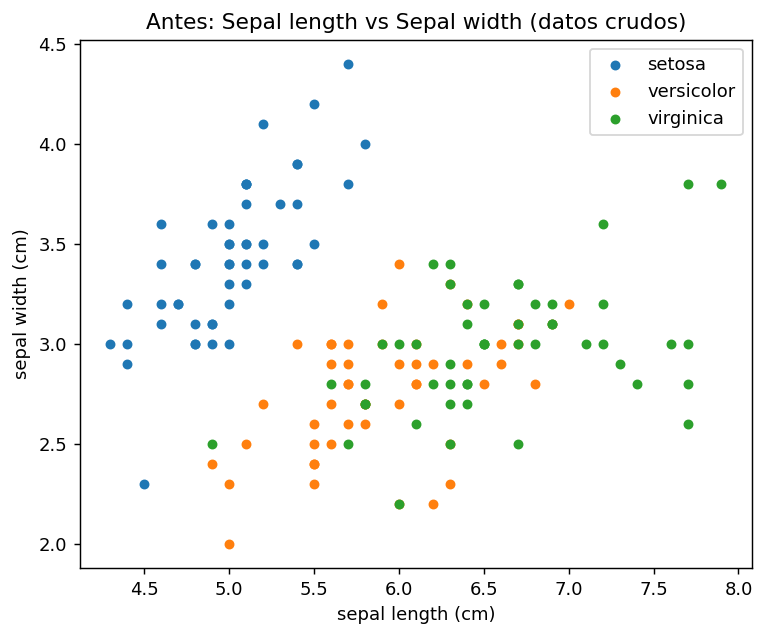

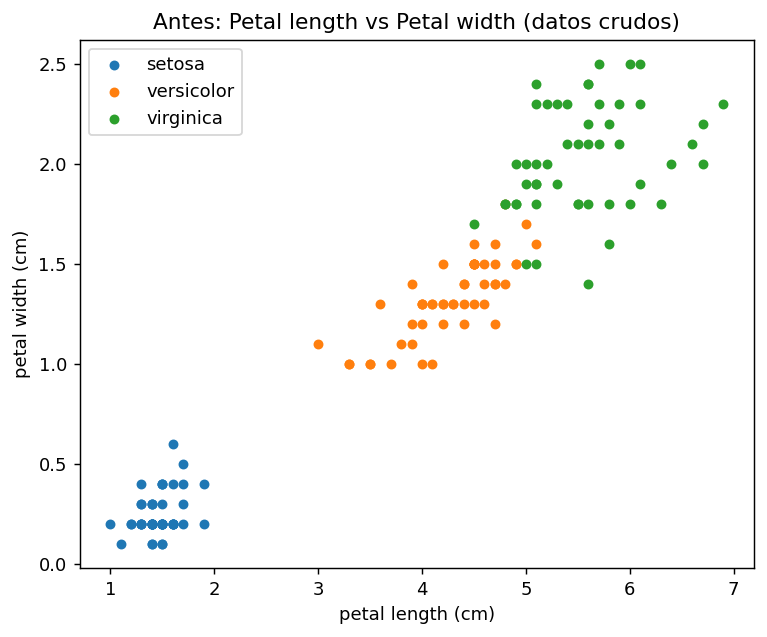


=== Métricas (macro) ===
Accuracy:  0.8947
Precision: 0.9030
Recall:    0.8974
F1-score:  0.8968

=== Reporte por clase ===
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.80      0.92      0.86        13
   virginica       0.91      0.77      0.83        13

    accuracy                           0.89        38
   macro avg       0.90      0.90      0.90        38
weighted avg       0.90      0.89      0.89        38



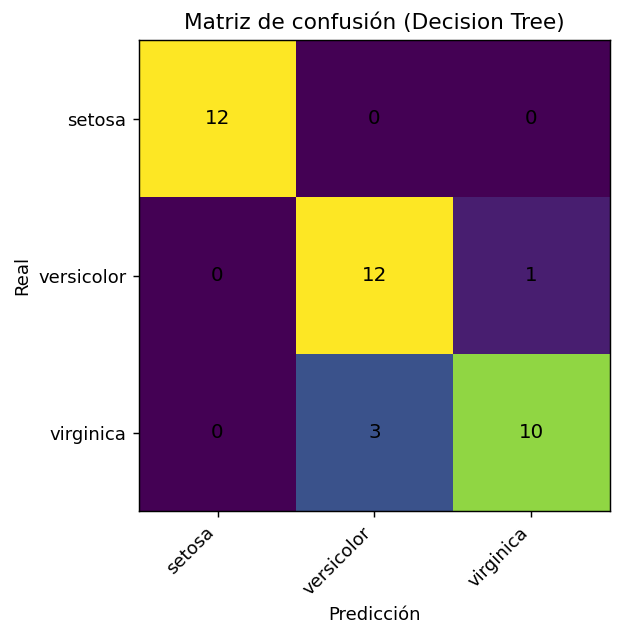

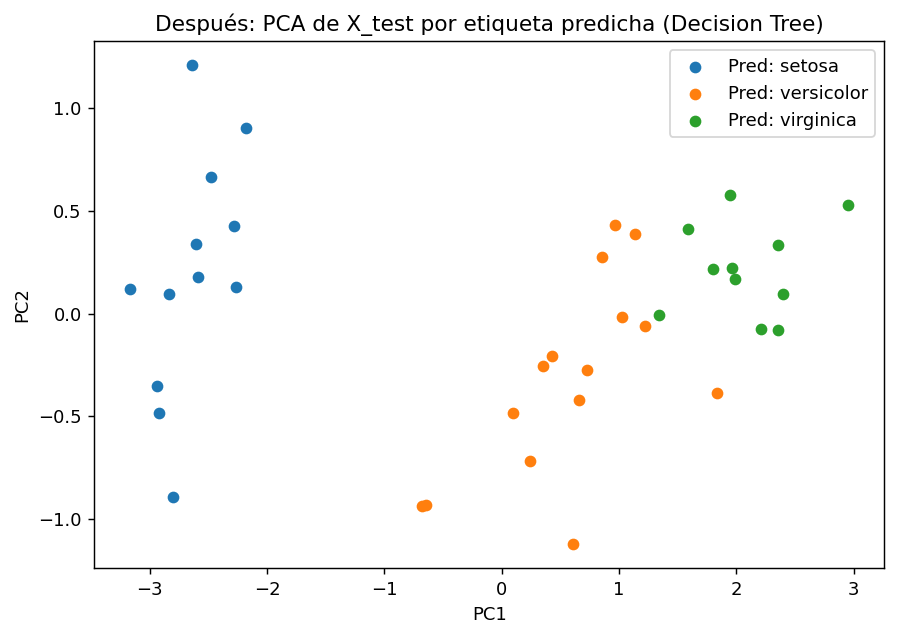

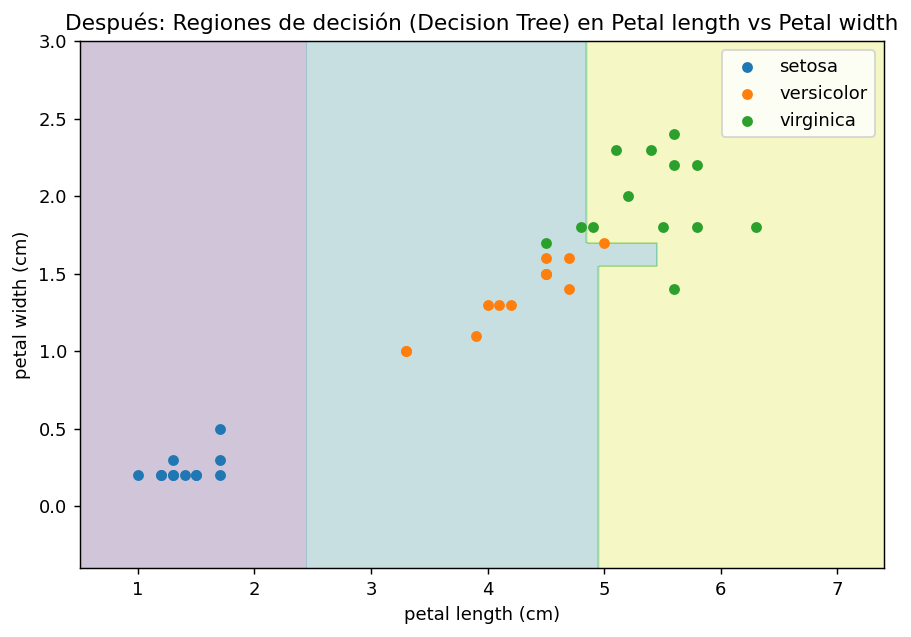

In [3]:
# === Iris + DecisionTreeClassifier (end-to-end) ===
# Requisitos: scikit-learn, numpy, pandas, matplotlib
# !pip install scikit-learn pandas matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA

# -----------------------------
# Parámetros
# -----------------------------
TEST_SIZE = 0.25
RANDOM_STATE = 42
# Hiperparámetros del árbol (ajústalos si quieres)
DT_CRITERION = "gini"     # "gini" o "entropy", también "log_loss"
DT_MAX_DEPTH = None       # p.ej. 3, 4, 5 para podar
DT_MIN_SAMPLES_LEAF = 1

# -----------------------------
# 1) Cargar dataset
# -----------------------------
iris = load_iris(as_frame=True)
X = iris.data.copy()
y = iris.target.copy()
target_names = iris.target_names

print("Shape X:", X.shape, "| clases:", list(target_names))

# -----------------------------
# 1.A) Gráficas 'antes' (datos crudos)
# -----------------------------
# Sepal length vs Sepal width
plt.figure(figsize=(6, 5), dpi=130)
for label in np.unique(y):
    m = (y == label)
    plt.scatter(X.loc[m, "sepal length (cm)"], X.loc[m, "sepal width (cm)"],
                label=target_names[label], s=20)
plt.title("Antes: Sepal length vs Sepal width (datos crudos)")
plt.xlabel("sepal length (cm)"); plt.ylabel("sepal width (cm)")
plt.legend(); plt.tight_layout(); plt.show()

# Petal length vs Petal width
plt.figure(figsize=(6, 5), dpi=130)
for label in np.unique(y):
    m = (y == label)
    plt.scatter(X.loc[m, "petal length (cm)"], X.loc[m, "petal width (cm)"],
                label=target_names[label], s=20)
plt.title("Antes: Petal length vs Petal width (datos crudos)")
plt.xlabel("petal length (cm)"); plt.ylabel("petal width (cm)")
plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# 2) Split + Entrenamiento
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

clf = DecisionTreeClassifier(
    criterion=DT_CRITERION,
    max_depth=DT_MAX_DEPTH,
    min_samples_leaf=DT_MIN_SAMPLES_LEAF,
    random_state=RANDOM_STATE
)
clf.fit(X_train, y_train)

# -----------------------------
# 3) Métricas
# -----------------------------
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\n=== Métricas (macro) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec_macro:.4f}")
print(f"Recall:    {recall_macro:.4f}")
print(f"F1-score:  {f1_macro:.4f}")

print("\n=== Reporte por clase ===")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# -----------------------------
# 4) Matriz de confusión
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5), dpi=130)
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión (Decision Tree)")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.xticks(np.arange(len(target_names)), target_names, rotation=45, ha="right")
plt.yticks(np.arange(len(target_names)), target_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=11)
plt.tight_layout(); plt.show()

# -----------------------------
# 5) Gráficas “después” de la clasificación
#    A) PCA 2D de X_test con etiquetas PREDICHAS
# -----------------------------
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_test_proj = pca.fit_transform(X_test)

plt.figure(figsize=(7, 5), dpi=130)
for label in np.unique(y_pred):
    m = (y_pred == label)
    plt.scatter(X_test_proj[m, 0], X_test_proj[m, 1],
                label=f"Pred: {target_names[label]}", s=30)
plt.title("Después: PCA de X_test por etiqueta predicha (Decision Tree)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# 5.B) Regiones de decisión (visualización 2D)
#     Usamos solo 2 características: petal length & petal width
# -----------------------------
feat_pair = ["petal length (cm)", "petal width (cm)"]
X2 = X[feat_pair].values

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

tree2d = DecisionTreeClassifier(
    criterion=DT_CRITERION,
    max_depth=DT_MAX_DEPTH,
    min_samples_leaf=DT_MIN_SAMPLES_LEAF,
    random_state=RANDOM_STATE
)
tree2d.fit(X2_train, y2_train)

# Malla para regiones
x_min, x_max = X2[:, 0].min() - 0.5, X2[:, 0].max() + 0.5
y_min, y_max = X2[:, 1].min() - 0.5, X2[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)
Z = tree2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(7, 5), dpi=130)
plt.contourf(xx, yy, Z, alpha=0.25)  # sin colores explícitos
# Puntos reales del test para distinguir datos
for label in np.unique(y2_test):
    m = (y2_test == label)
    pts = X2_test[m]
    plt.scatter(pts[:, 0], pts[:, 1], label=target_names[label], s=25)

plt.title("Después: Regiones de decisión (Decision Tree) en Petal length vs Petal width")
plt.xlabel(feat_pair[0]); plt.ylabel(feat_pair[1])
plt.legend(); plt.tight_layout(); plt.show()


Shape X: (150, 4) | clases: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]


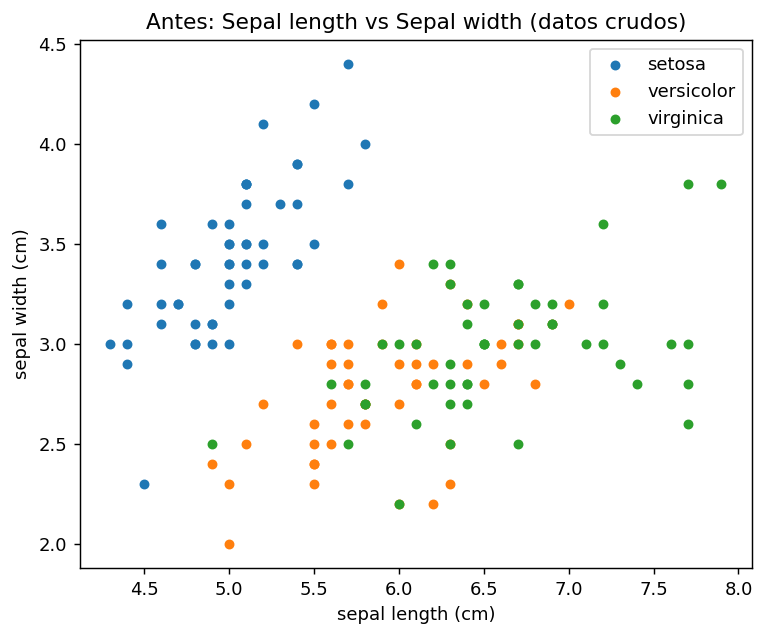

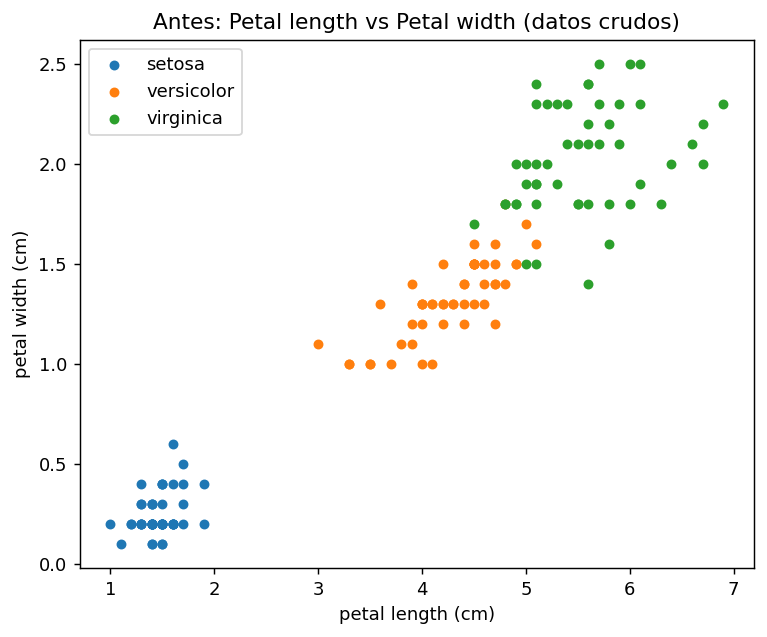


=== Métricas (macro) ===
Accuracy:  0.8947
Precision: 0.9030
Recall:    0.8974
F1-score:  0.8968

=== Reporte por clase ===
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.80      0.92      0.86        13
   virginica       0.91      0.77      0.83        13

    accuracy                           0.89        38
   macro avg       0.90      0.90      0.90        38
weighted avg       0.90      0.89      0.89        38



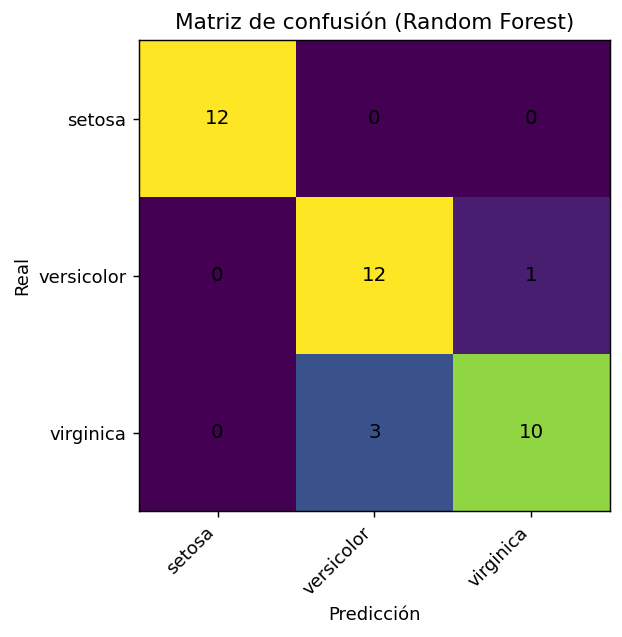

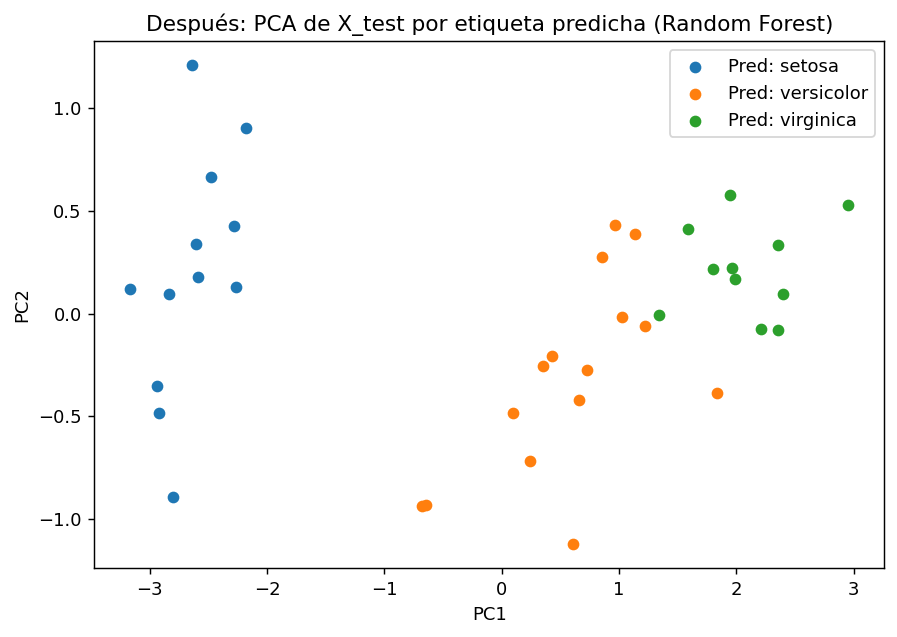

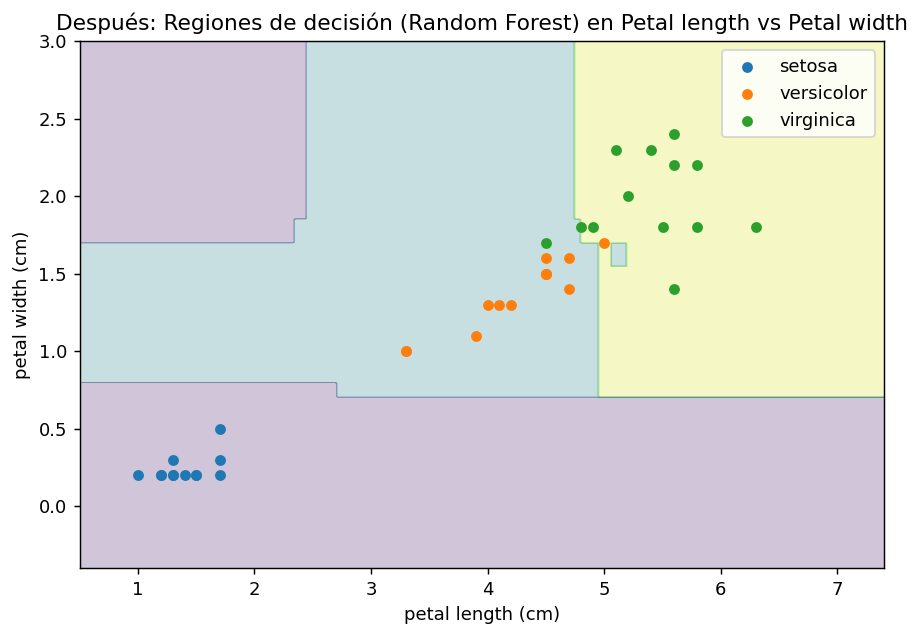

In [1]:
# === Iris + RandomForestClassifier (end-to-end) ===
# Requisitos: scikit-learn, numpy, pandas, matplotlib
# !pip install scikit-learn pandas matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA

# -----------------------------
# Parámetros
# -----------------------------
TEST_SIZE = 0.25
RANDOM_STATE = 42
RF_N_ESTIMATORS = 200
RF_MAX_DEPTH = None
RF_MIN_SAMPLES_LEAF = 1

# -----------------------------
# 1) Cargar dataset
# -----------------------------
iris = load_iris(as_frame=True)
X = iris.data.copy()
y = iris.target.copy()
target_names = iris.target_names

print("Shape X:", X.shape, "| clases:", list(target_names))

# -----------------------------
# 1.A) Gráficas 'antes' (datos crudos)
# -----------------------------
# Sepal length vs Sepal width
plt.figure(figsize=(6, 5), dpi=130)
for label in np.unique(y):
    m = (y == label)
    plt.scatter(X.loc[m, "sepal length (cm)"], X.loc[m, "sepal width (cm)"],
                label=target_names[label], s=20)
plt.title("Antes: Sepal length vs Sepal width (datos crudos)")
plt.xlabel("sepal length (cm)"); plt.ylabel("sepal width (cm)")
plt.legend(); plt.tight_layout(); plt.show()

# Petal length vs Petal width
plt.figure(figsize=(6, 5), dpi=130)
for label in np.unique(y):
    m = (y == label)
    plt.scatter(X.loc[m, "petal length (cm)"], X.loc[m, "petal width (cm)"],
                label=target_names[label], s=20)
plt.title("Antes: Petal length vs Petal width (datos crudos)")
plt.xlabel("petal length (cm)"); plt.ylabel("petal width (cm)")
plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# 2) Split + Entrenamiento
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=RF_N_ESTIMATORS,
    max_depth=RF_MAX_DEPTH,
    min_samples_leaf=RF_MIN_SAMPLES_LEAF,
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)

# -----------------------------
# 3) Métricas
# -----------------------------
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\n=== Métricas (macro) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec_macro:.4f}")
print(f"Recall:    {recall_macro:.4f}")
print(f"F1-score:  {f1_macro:.4f}")

print("\n=== Reporte por clase ===")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# -----------------------------
# 4) Matriz de confusión
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5), dpi=130)
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión (Random Forest)")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.xticks(np.arange(len(target_names)), target_names, rotation=45, ha="right")
plt.yticks(np.arange(len(target_names)), target_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=11)
plt.tight_layout(); plt.show()

# -----------------------------
# 5) Gráficas “después” de la clasificación
#    A) PCA 2D de X_test con etiquetas PREDICHAS
# -----------------------------
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_test_proj = pca.fit_transform(X_test)

plt.figure(figsize=(7, 5), dpi=130)
for label in np.unique(y_pred):
    m = (y_pred == label)
    plt.scatter(X_test_proj[m, 0], X_test_proj[m, 1],
                label=f"Pred: {target_names[label]}", s=30)
plt.title("Después: PCA de X_test por etiqueta predicha (Random Forest)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# 5.B) Regiones de decisión (visualización 2D)
#     Usamos solo 2 características: petal length & petal width
# -----------------------------
feat_pair = ["petal length (cm)", "petal width (cm)"]
X2 = X[feat_pair].values

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

rf2d = RandomForestClassifier(
    n_estimators=RF_N_ESTIMATORS,
    max_depth=RF_MAX_DEPTH,
    min_samples_leaf=RF_MIN_SAMPLES_LEAF,
    random_state=RANDOM_STATE
)
rf2d.fit(X2_train, y2_train)

# Malla para regiones
x_min, x_max = X2[:, 0].min() - 0.5, X2[:, 0].max() + 0.5
y_min, y_max = X2[:, 1].min() - 0.5, X2[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)
Z = rf2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(7, 5), dpi=130)
plt.contourf(xx, yy, Z, alpha=0.25)  # sin colores explícitos
# Puntos reales del test para distinguir datos
for label in np.unique(y2_test):
    m = (y2_test == label)
    pts = X2_test[m]
    plt.scatter(pts[:, 0], pts[:, 1], label=target_names[label], s=25)

plt.title("Después: Regiones de decisión (Random Forest) en Petal length vs Petal width")
plt.xlabel(feat_pair[0]); plt.ylabel(feat_pair[1])
plt.legend(); plt.tight_layout(); plt.show()


Shape X: (150, 4) | clases: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]


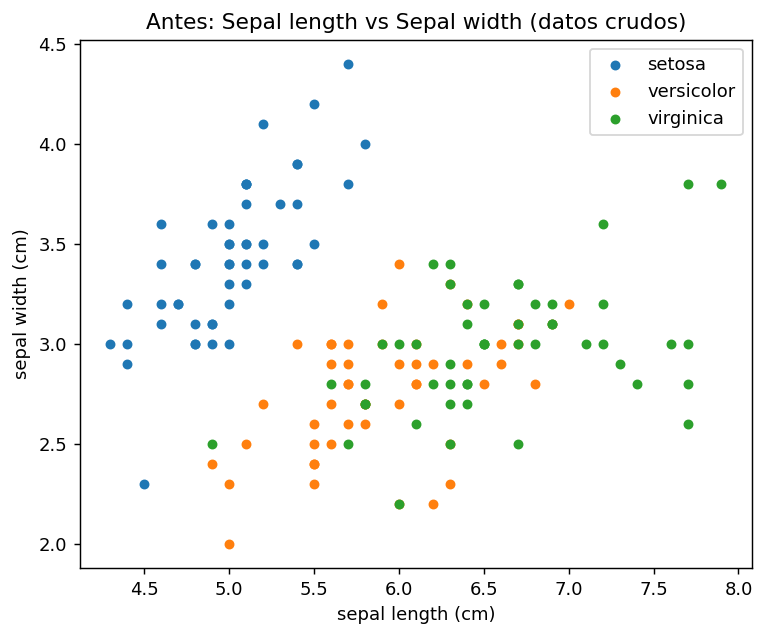

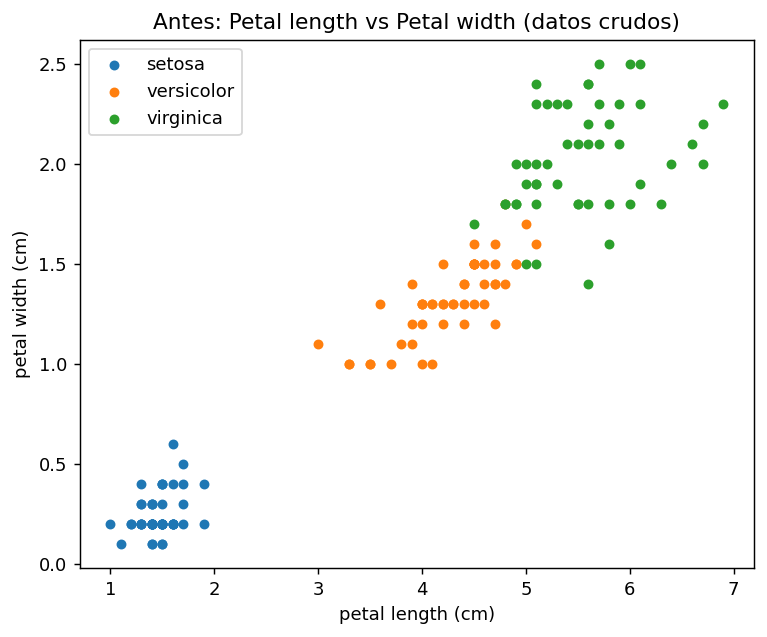


=== Métricas (macro) ===
Accuracy:  0.9737
Precision: 0.9762
Recall:    0.9744
F1-score:  0.9743

=== Reporte por clase ===
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       1.00      0.92      0.96        13
   virginica       0.93      1.00      0.96        13

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



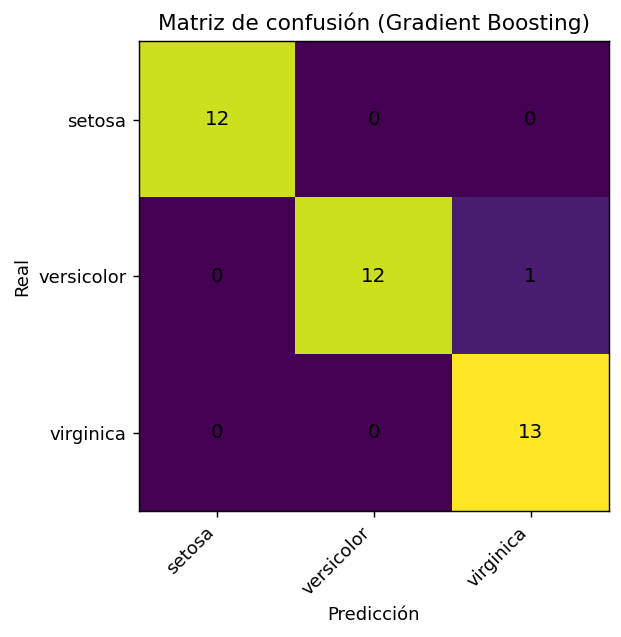

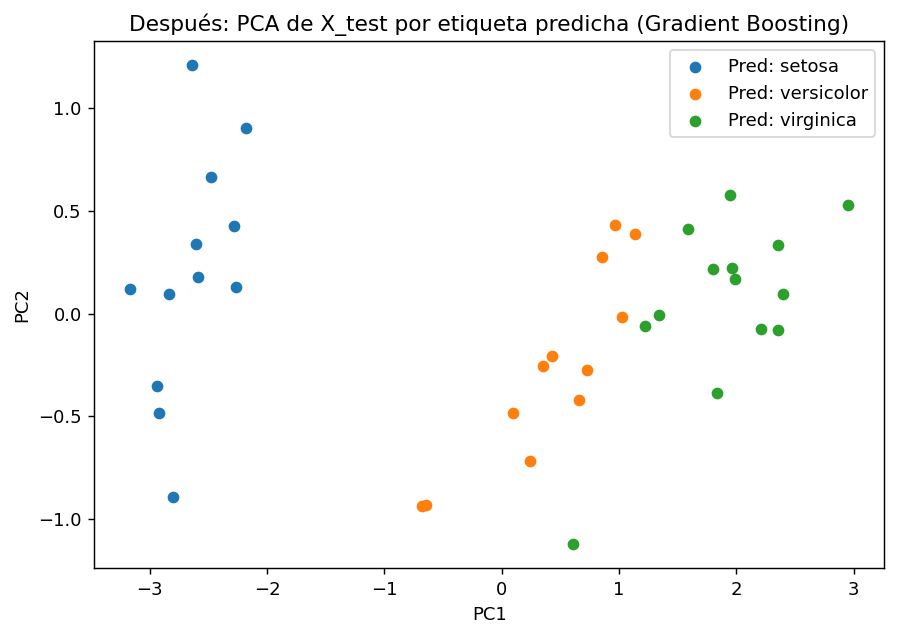

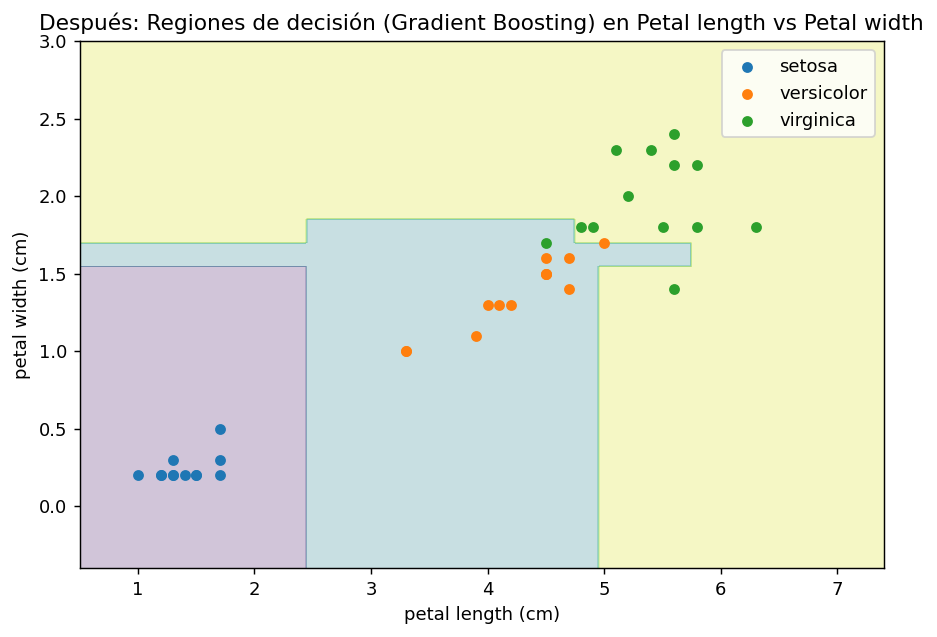

In [2]:
# === Iris + GradientBoostingClassifier (end-to-end) ===
# Requisitos: scikit-learn, numpy, pandas, matplotlib
# !pip install scikit-learn pandas matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA

# -----------------------------
# Parámetros
# -----------------------------
TEST_SIZE = 0.25
RANDOM_STATE = 42
GB_N_ESTIMATORS = 200
GB_LEARNING_RATE = 0.1
GB_MAX_DEPTH = 3

# -----------------------------
# 1) Cargar dataset
# -----------------------------
iris = load_iris(as_frame=True)
X = iris.data.copy()
y = iris.target.copy()
target_names = iris.target_names

print("Shape X:", X.shape, "| clases:", list(target_names))

# -----------------------------
# 1.A) Gráficas 'antes' (datos crudos)
# -----------------------------
# Sepal length vs Sepal width
plt.figure(figsize=(6, 5), dpi=130)
for label in np.unique(y):
    m = (y == label)
    plt.scatter(X.loc[m, "sepal length (cm)"], X.loc[m, "sepal width (cm)"],
                label=target_names[label], s=20)
plt.title("Antes: Sepal length vs Sepal width (datos crudos)")
plt.xlabel("sepal length (cm)"); plt.ylabel("sepal width (cm)")
plt.legend(); plt.tight_layout(); plt.show()

# Petal length vs Petal width
plt.figure(figsize=(6, 5), dpi=130)
for label in np.unique(y):
    m = (y == label)
    plt.scatter(X.loc[m, "petal length (cm)"], X.loc[m, "petal width (cm)"],
                label=target_names[label], s=20)
plt.title("Antes: Petal length vs Petal width (datos crudos)")
plt.xlabel("petal length (cm)"); plt.ylabel("petal width (cm)")
plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# 2) Split + Entrenamiento
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

gb = GradientBoostingClassifier(
    n_estimators=GB_N_ESTIMATORS,
    learning_rate=GB_LEARNING_RATE,
    max_depth=GB_MAX_DEPTH,
    random_state=RANDOM_STATE
)
gb.fit(X_train, y_train)

# -----------------------------
# 3) Métricas
# -----------------------------
y_pred = gb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\n=== Métricas (macro) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec_macro:.4f}")
print(f"Recall:    {recall_macro:.4f}")
print(f"F1-score:  {f1_macro:.4f}")

print("\n=== Reporte por clase ===")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# -----------------------------
# 4) Matriz de confusión
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5), dpi=130)
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión (Gradient Boosting)")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.xticks(np.arange(len(target_names)), target_names, rotation=45, ha="right")
plt.yticks(np.arange(len(target_names)), target_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=11)
plt.tight_layout(); plt.show()

# -----------------------------
# 5) Gráficas “después” de la clasificación
#    A) PCA 2D de X_test con etiquetas PREDICHAS
# -----------------------------
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_test_proj = pca.fit_transform(X_test)

plt.figure(figsize=(7, 5), dpi=130)
for label in np.unique(y_pred):
    m = (y_pred == label)
    plt.scatter(X_test_proj[m, 0], X_test_proj[m, 1],
                label=f"Pred: {target_names[label]}", s=30)
plt.title("Después: PCA de X_test por etiqueta predicha (Gradient Boosting)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# 5.B) Regiones de decisión (visualización 2D)
#     Usamos solo 2 características: petal length & petal width
# -----------------------------
feat_pair = ["petal length (cm)", "petal width (cm)"]
X2 = X[feat_pair].values

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

gb2d = GradientBoostingClassifier(
    n_estimators=GB_N_ESTIMATORS,
    learning_rate=GB_LEARNING_RATE,
    max_depth=GB_MAX_DEPTH,
    random_state=RANDOM_STATE
)
gb2d.fit(X2_train, y2_train)

# Malla para regiones
x_min, x_max = X2[:, 0].min() - 0.5, X2[:, 0].max() + 0.5
y_min, y_max = X2[:, 1].min() - 0.5, X2[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 400),
    np.linspace(y_min, y_max, 400)
)
Z = gb2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(7, 5), dpi=130)
plt.contourf(xx, yy, Z, alpha=0.25)
for label in np.unique(y2_test):
    m = (y2_test == label)
    pts = X2_test[m]
    plt.scatter(pts[:, 0], pts[:, 1], label=target_names[label], s=25)

plt.title("Después: Regiones de decisión (Gradient Boosting) en Petal length vs Petal width")
plt.xlabel(feat_pair[0]); plt.ylabel(feat_pair[1])
plt.legend(); plt.tight_layout(); plt.show()
